## Dataset Preparation

In [5]:
import numpy as np
import os
from pathlib import Path
from tensorflow.keras.preprocessing import image

In [6]:
p = Path("images")

dirs = p.glob('*')

for folder_name in dirs:
    print(folder_name)
    label = str(folder_name).split("\\")[-1]
    print(label)

images\cats
cats
images\dogs
dogs
images\horses
horses
images\humans
humans


In [11]:
p = Path("images")

dirs = p.glob('*')

labels_dict = {'cat':0,'dog':1,'horse':2,'human':3}
image_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]
    
    for img_path in folder_dir.glob('*.jpg'):
        # print(img_path)
        img = image.load_img(img_path,target_size = (100,100))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [12]:
print(len(image_data))

808


In [13]:
print(len(labels))

808


In [16]:
image_data = np.array(image_data,dtype='float32')/255.0
labels = np.array(labels)
print(image_data.shape)
print(labels.shape)

(808, 100, 100, 3)
(808,)


### Visualise the Data

In [17]:
import matplotlib.pyplot as plt

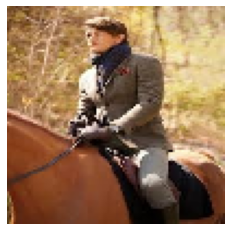

In [21]:
def drawImg(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return

drawImg(image_data[0])

### Randomly Shuffle our data

In [22]:
import random

combined = list(zip(image_data,labels))
random.shuffle(combined)

# Unzip
image_data[:],labels[:] = zip(*combined)

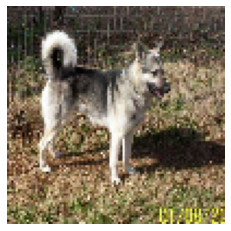

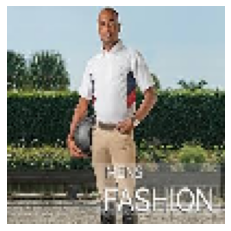

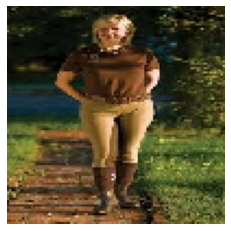

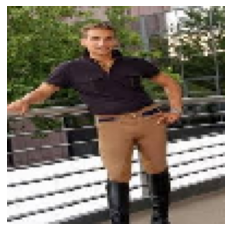

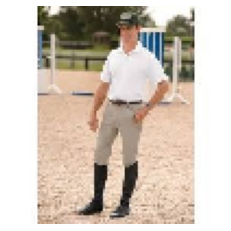

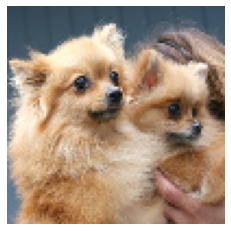

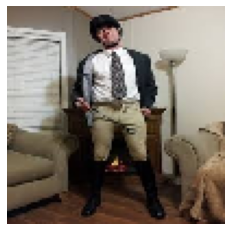

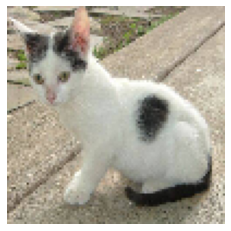

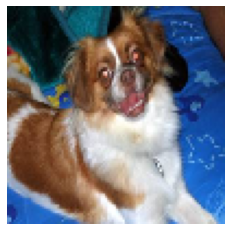

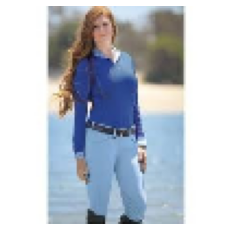

In [23]:
for i in range(10):
    drawImg(image_data[i])

### SVM Classifier

In [24]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=50,learning_rate=0.001,maxItr=500):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        
        #Initial Loss
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses

### We need to convert Data for one vs one classification

In [25]:
M = image_data.shape[0]
image_data = image_data.reshape((M,-1))
print(image_data.shape)
print(labels.shape)

(808, 30000)
(808,)


In [26]:
classes = len(np.unique(labels))
print(classes)

4


In [29]:
def classWiseData(x,y):
    data = {}
    
    for i in range(classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [30]:
data = classWiseData(image_data,labels)

In [32]:
print(data[0].shape[0])
print(data[1].shape[0])
print(data[2].shape[0])
print(data[3].shape[0])

202
202
202
202


In [33]:
def getDataPairForSVM(d1,d2):
    """Combines Data of two classes into a single matrix"""
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1
    
    return data_pair,data_labels

### Training NC2 SVM's

In [37]:
mySVM = SVM()

In [48]:
def trainSVMs(x,y):
    
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i] = {}
        for j in range(i+1,classes):
            xpair,ypair = getDataPairForSVM(data[i],data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.000001,maxItr=5000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            
    return svm_classifiers

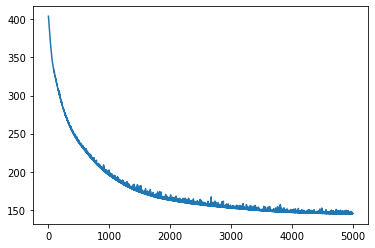

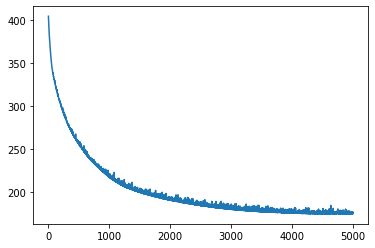

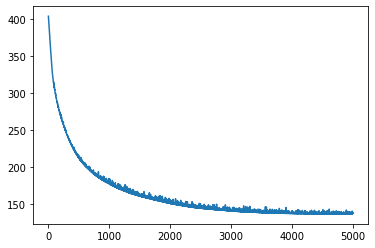

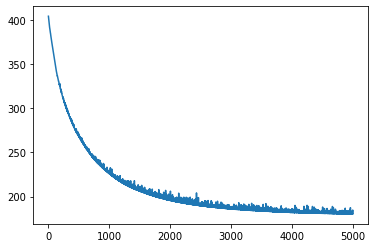

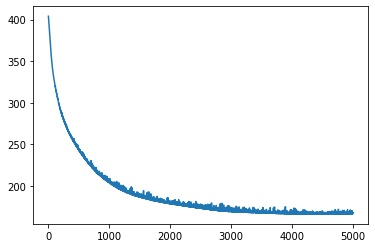

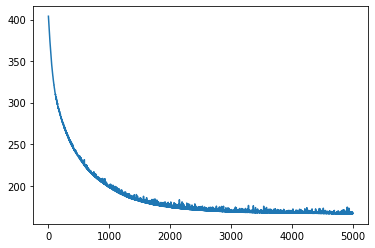

In [49]:
svm_classifiers = trainSVMs(image_data,labels)

In [50]:
#Parameters for Cats and dogs
cats_dogs = svm_classifiers[0][1]
cats_humans = svm_classifiers[0][3]
print(cats_dogs[0].shape)
print(cats_dogs[1])

(1, 30000)
-0.007299000000000039


### Prediction

In [51]:
def binaryPredict(x,w,b):
    z  = np.dot(x,w.T) + b
    if z>=0:
        return 1
    else:
        return -1

In [52]:
def predict(x):
    
    count = np.zeros((classes,))
    
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return final_prediction

In [53]:
print(predict(image_data[0]))
print(labels[0])

3
1


In [54]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [55]:
accuracy(image_data,labels)

0.568069306930693

### SVM using Sklearn

In [56]:
from sklearn import svm
svm_classifier = svm.SVC(kernel='linear',C=1.0)
svm_classifier.fit(image_data,labels)
svm_classifier.score(image_data,labels)

0.5693069306930693